# Exploring the Explanatory Power of Age

I'd like to know if the age of a user has any bearing on match percent. This is a fairly straightforward linear model--simply predict match percent with age. I'll also explore the effect of controlling for gender and sexual orientation in the model, but the interpretation of any effect there is difficult--since match percent is some measure of how my responses to questions match with another user and vice versa, societal norms and their influence play a part in many ways: users encoding our own biases and beliefs into the responses to the questions posed to us, the phrasing of questions and answer choices on the site, and the underlying model of matching that the site uses all will encoded biases into match percentages, but how and to what extent is impossible without access to the underlying models and individual questions. For that reason, I have no prediction of how including these controls will affect the results and no insight on how to interpret any effect therein. 


In [1]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import statsmodels.formula.api as smf

np.set_printoptions(suppress=True)

## Loading Data

We'll start by querying the SQLite database, pulling in the data we need and creating a few dummy variables from the `basic_info` field, which is a text field with info about sexual orientation, gender identity, body type, relationship status, etc. The response categories here are finite but vast: gender identity, for example, has as many as 20 possible selections and the user can select up to five to appear. Here I'll break it down to just "Woman", "Man", and "Other". 

I already parsed age out of the data in the process of scraping it, so we can avoid that part here. 

In [3]:
db = 'sqlite:///data/userdata.db'

sql = """
select 
  username, 
  age, 
  match_pct, 
  enemy_pct,
  religion_pct,
  CASE WHEN basic_info like "%Woman%" THEN 1 ELSE 0 END AS gender_female,
  CASE WHEN basic_info like "%Man%" THEN 1 ELSE 0 END AS gender_male,
  CASE WHEN basic_info like "%Straight%" THEN 1 ELSE 0 END AS is_straight
from tbl_userdata
"""

In [4]:
df = pd.read_sql(sql=sql, con=db,index_col='username')

In [5]:
df['gender_other'] = (df['gender_female'] + df['gender_male'] == 0) * 1

## Exploring the data

If we take a look at the histogram of the various match percent metrics pulled, we see that all are zero truncated. Because a value of zero often means the user answered no questions, not that the actual match is that low, we can safely set any cases where match is zero to missing. 

We can also see that we're running pretty low on religion percent data and it's more highly skewed than the match and enemy percentages. It'll be interesting to compare the trends we see with religion to the others and see where differences crop up. 

<Figure size 432x288 with 0 Axes>

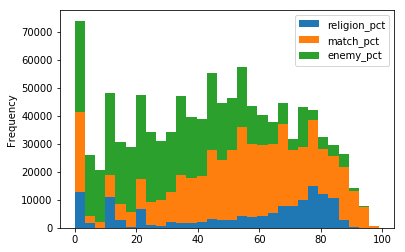

In [6]:
plt.figure();
df[['religion_pct', 'match_pct', 'enemy_pct']].plot.hist(stacked=True, bins=30);

## Analysis

My hypothesis is that there will be no discernible trend in match or enemy percent by age, but religion percent will show higher matches with young people than older people. I base this only on the fact that atheism is on the rise, so young people are more likely to be atheist and thus, more like to match with me in religious belief than older people. I'd also _might_ guess that if I control for sexual orientation and gender, we'll see an age effect appear in the match percent category. This is based on the idea that if we are able to add in controls for gender identities outside the binary and sexual orientations other than 'straight', we'll see that younger progressives are more in line with my beliefs than older progressives. This assumes that we can proxy "progressive" using identity and orientation only (which fails the sniff test, but alas, this is for fun). 

If we start by plotting the data, we see this effect I predicted when paneling by the `gender_other` variable: that there is no age effect in general, but we do see an effect for individuals not identifying as a Man or a Woman. 

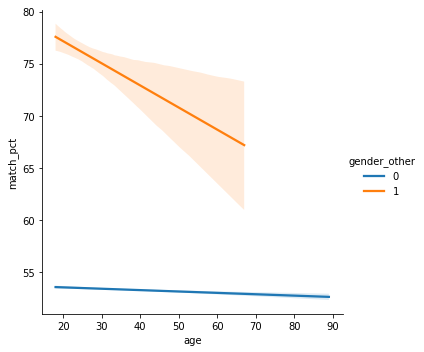

In [7]:
sns.lmplot(x='age', 
           y='match_pct', 
           hue='gender_other',
           data=df, 
           scatter=False, 
           truncate=True)

In [8]:
fit1 = smf.ols('match_pct ~ age * gender_other + is_straight', data=df).fit()
fit1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              match_pct   R-squared:                       0.029
Model:                            OLS   Adj. R-squared:                  0.029
Method:                 Least Squares   F-statistic:                     3578.
Date:                Thu, 16 Aug 2018   Prob (F-statistic):               0.00
Time:                        11:37:17   Log-Likelihood:            -2.2068e+06
No. Observations:              480654   AIC:                         4.414e+06
Df Residuals:                  480649   BIC:                         4.414e+06
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept           64.5589      0.148    435.779      0.000      64.269      64.849
age                  0.0514      0.003     16.570      0.000       0.045       0.057
gender_other        15.9535      2.226      7.168      0.000      11.591      20.316
age:gender_other    -0.1778      0.082     -2.178      0.029      -0.338      -0.018
is_straight        -14.2775      0.126   -113.499      0.000     -14.524     -14.031
==============================================================================
Omnibus:                    22613.270   Durbin-Watson:                   1.873
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            24616.731
Skew:                          -0.534   Prob(JB):                         0.00
Kurtosis:                       2.705   Cond. No.                     2.42e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.42e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

Taking a look at the coefficients, we also see very strong effects for out gender identity and sexual orientation controls and fairly low standard error across the board. P-values are all significant, but we have a lot of data (almost 500k users), so this is expected. We might consider this an exciting finding until we take a look at the R-squared value. 

In [9]:
print(fit1.rsquared_adj.round(4))

0.0289


Our predictors can only account for 3% of the variance in match percent. And if we look at a model where we're not controlling for gender or sexual orientation at all, that values approaches zero.

In [10]:
smf.ols('match_pct ~ age', data=df).fit().rsquared_adj.round(6)

7.6e-05

So almost all of that explanatory power comes from our demographic controls, not from age. Enemy percent is the same story.

In [11]:
print("R-squared with controls:", smf.ols('enemy_pct ~ age * gender_other + is_straight', data=df).fit().rsquared_adj.round(4))
print("R-squared reduced:", smf.ols('enemy_pct ~ age', data=df).fit().rsquared_adj.round(6))

R-squared with controls: 0.0256
R-squared reduced: 0.001256


### Domain-specific Match: Religion

If we look at a domain-specific match metric like religion, as I said earlier, I expect to see more of an age trend, since this ends up being more of a proxy for generational attitudes that match with mine. An initial plot of the data supports this. 

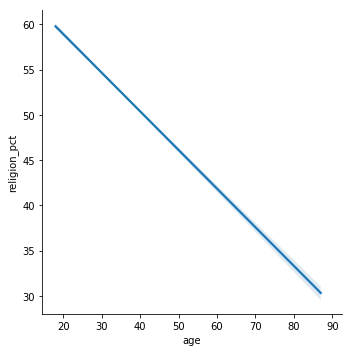

In [12]:
sns.lmplot(x='age', 
           y='religion_pct', 
           data=df, 
           scatter=False, 
           truncate=True)

It is important to note that a simple linear model may not suffice here. Quadratic effects seem like an important angle to explore, given that there may be an ideal age here. This is also true of the match and enemy percent data. 

In [13]:
df['age2'] = df.age.pow(2)
fit2 = smf.ols('religion_pct ~ age+age2 + age*age2 + gender_other + is_straight', data=df).fit()
fit2_redux = smf.ols('religion_pct ~ age+age2 + age*age2', data=df).fit()
fit2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           religion_pct   R-squared:                       0.045
Model:                            OLS   Adj. R-squared:                  0.045
Method:                 Least Squares   F-statistic:                     1300.
Date:                Thu, 16 Aug 2018   Prob (F-statistic):               0.00
Time:                        11:37:30   Log-Likelihood:            -6.5554e+05
No. Observations:              137337   AIC:                         1.311e+06
Df Residuals:                  137331   BIC:                         1.311e+06
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept       -7.6628      2.256     -3.397      0.001     -12.084      -3.241
age              5.8425      0.176     33.279      0.000       5.498       6.187
age2            -0.1467      0.004    -34.266      0.000      -0.155      -0.138
age:age2         0.0011   3.31e-05     32.659      0.000       0.001       0.001
gender_other     5.3125      1.023      5.195      0.000       3.308       7.317
is_straight     -9.5889      0.243    -39.467      0.000     -10.065      -9.113
==============================================================================
Omnibus:                    37577.920   Durbin-Watson:                   1.890
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            13661.637
Skew:                          -0.591   Prob(JB):                         0.00
Kurtosis:                       2.005   Cond. No.                     2.52e+06
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.52e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [14]:
x_predict = pd.DataFrame({'age': range(20,80),
                         'gender_other': df['gender_other'].mean(),
                         'is_straight': df['is_straight'].mean()})
x_predict['age2'] = x_predict['age'].pow(2)

pred = fit2.get_prediction(x_predict)
pred_df = pred.summary_frame()
pred_df['age'] = x_predict['age']

pred_redux = fit2_redux.get_prediction(x_predict)
pred_df_redux = pred_redux.summary_frame()
pred_df_redux['age'] = x_predict['age']

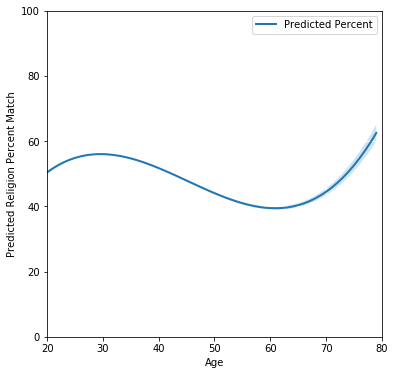

In [15]:
def plot_eff(x, data, y='mean', ci_low='mean_ci_lower', ci_upp='mean_ci_upper', xlab=None, ylab=None):
    plt.figure(figsize=(6, 6))
    ax = plt.subplot(111)
    ax.plot(data[x], data[y], '-', lw=2, label = "Predicted Percent")
    ax.fill_between(data[x], data[ci_low], data[ci_upp], alpha=0.2)
    ax.legend(loc='best');
    ax.grid(b=True, which='major', color='w', linewidth=1.0)
    ax.grid(b=True, which='minor', color='w', linewidth=0.5)

    ax.set_xlabel(xlab)
    ax.set_ylabel(ylab)
    ax.set_ylim([0, 100])
    ax.set_xlim([20, 80])
    plt.show()
    return plt

plot_eff(x='age', data=pred_df, xlab='Age', ylab='Predicted Religion Percent Match');
#plot_eff(x='age', data=pred_df_redux, xlab='Age', ylab='Predicted Religion Percent Match');

Adding in the quadratic effect shows a significant effect, with a maxima in the late-20's, which again, if we are seeing this as a proxy for generational attitudes towards religion, this makes sense. But again, our R-squared is low (0.045) and this model has next to no explanatory power.      

## Conclusion

This is what I had hoped to find from this analysis. A metric that determines matches on a dating site _should_ be orthogonal to age. Since a user can see another user's age, that piece of info can be part of that user's evaluation of the potential match and shouldn't be also encoded into the match percent value shown to the user. 

The presence and absence of an effect for the `gender_other` control also I think says something about latent constructs that accompany the use of non-binary genders, the increase of acceptance of non-binary genders in younger generations, and my own identity in that domain. I think including that control in analysis of age in relation to match percent offers some interesting insights to cohort effects, but is ultimately the incorrect methodology to tease out these effects. 